In [49]:
import os 
import sys

import sklearn as sk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import xgboost as xgb

from scipy.stats import kurtosis, entropy
from scipy.fft import fft

sys.path.append(r"c:\Users\keng-tse\Desktop\csi_tool") #這行為絕對路徑，如需使用，必須要修改為當前決路徑
import csi_tool
import denoise 

In [51]:
def load_data(reference_points):
    data = []          # 用于存储所有数据
    rp_labels = []     # 用于存储参考点编号标签
    coord_labels = []  # 用于存储 (x, y) 坐标标签

    for path, (ref_id, coord) in reference_points.items():
        df = pd.read_excel(path)
        data.append(df.values)
        rp_labels.extend([ref_id] * len(df))
        coord_labels.extend([coord] * len(df))
    data = pd.DataFrame(np.vstack(data))
    rp_labels = pd.Series(rp_labels, name="Reference Point ID")
    coord_labels = pd.DataFrame(coord_labels, columns=["X", "Y"])
    return data, rp_labels, coord_labels

In [67]:
data = df = pd.read_excel(r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone_pi2\test\csv\test_80_l.xlsx")

In [68]:
data

,140.91132,124.149104,107.01869,96.896852,90.603532,89.106678,95.425364,99.538937,111.830228,119.004202,...,1.678822,1.390227,1.092746,0.793541,0.482806,0.153904,-0.188446,-0.5478635315.1,-57,136
0,127.424487,120.353646,110.819673,99.282425,94.021274,90.906545,93.648278,99.724621,106.531685,115.039124,...,2.011227,1.686096,1.350778,1.003102,0.638107,0.250737,-0.152101,-0.559354,-57,136
1,124.016128,108.074049,100.568385,86.954011,82.134037,79.195959,87.920419,100.304536,105.801701,109.018347,...,-3.052161,2.944197,2.625712,2.322901,1.986886,1.634565,1.273924,0.894906,-57,136
2,138.293167,125.483067,109.110036,98.792712,91.923882,93.295230,96.135321,100.498756,103.097042,109.562767,...,-2.278934,-2.635042,-2.995053,2.920084,2.540194,2.142204,1.721275,1.289870,-57,136
3,133.660016,117.239072,102.357218,96.130120,85.287748,79.831072,82.873397,84.970583,92.800862,100.448992,...,1.941688,1.664344,1.377734,1.080285,0.766725,0.436849,0.095765,-0.231438,-57,136
4,17.804494,8.602325,5.000000,7.211103,18.384776,11.180340,9.055385,34.365681,21.000000,9.219544,...,-0.800307,-1.077253,-1.360287,-1.658450,-1.969688,-2.290059,-2.639945,-3.005921,-55,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,105.109467,102.961158,93.021503,91.219515,88.141931,93.813645,103.966341,115.762688,121.148669,125.131930,...,0.822538,0.545550,0.263780,-0.045100,-0.361699,-0.698257,-1.034056,-1.353291,-57,136
995,124.354332,111.803399,102.215459,91.923882,84.202138,81.584312,85.375641,95.021050,105.223572,113.841996,...,0.054816,-0.211172,-0.487379,-0.771268,-1.072310,-1.385523,-1.700083,-1.999177,-57,136
996,95.078915,95.257546,88.600226,81.320354,81.024688,87.321246,97.308787,105.990566,114.109596,119.820699,...,0.397418,0.140263,-0.135633,-0.420128,-0.713255,-1.017022,-1.329043,-1.629480,-57,136
997,85.842880,77.388630,78.746428,82.969874,88.119237,95.524866,105.118980,108.466585,113.110565,118.473626,...,1.232689,0.738279,0.246115,-0.267488,-0.803977,-1.359197,-1.910629,-2.477301,-57,136


In [71]:
amp1 = data.iloc[:,234:-2]
amp1_p = denoise.preprocess_csi_for_fingerprint2(np.array(amp1))

In [73]:
data2 = pd.read_excel(r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone_pi2\test\csv\test_80_s.xlsx")

In [74]:
amp2 = data2.iloc[:,234:-2]
amp2_p = denoise.preprocess_csi_for_fingerprint2(np.array(amp2))

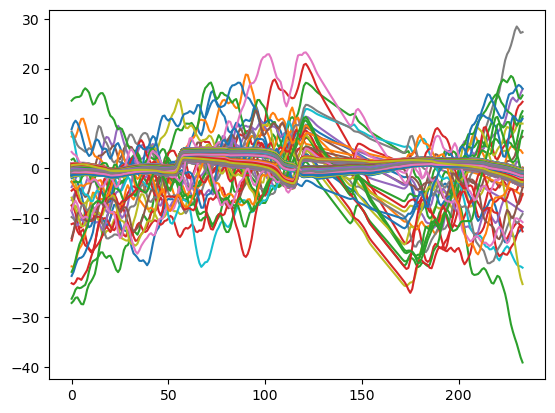

In [87]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def correct_cfo_sfo2(phase_matrix):
    """
    改進版的 CSI 相位校正函數。
    :param phase_matrix: numpy array, 每列表示一組子載波的相位 (shape: [num_packets, num_subcarriers])
    :return: numpy array, 校正後的 CSI 相位 (shape: [num_packets, num_subcarriers])
    """
    num_packets, num_subcarriers = phase_matrix.shape
    corrected_phase = np.zeros_like(phase_matrix)
    I = np.arange(-117, 117)  # 子載波索引（可根據實際數據調整範圍）

    for n in range(num_packets):
        # 平滑處理
        theta_n = gaussian_filter(phase_matrix[n, :], sigma=1)
        #theta_n = phase_matrix[n,:]
        # 最小二平方估計一條由 SFO 和 CFO 造成的線性偏差
        a = np.sum(I * (theta_n - np.mean(theta_n))) / np.sum(I**2)
        b = np.median(theta_n)
        
        # 校正相位
        corrected_phase[n, :] = theta_n - a * I - b
        
        # 防止過度偏移，調整均值
        #corrected_phase[n, :] -= np.mean(corrected_phase[n, :])

    return corrected_phase


phase = np.unwrap(amp1)
phase = correct_cfo_sfo2(phase)
phase2 = np.unwrap(amp2)
phase2= correct_cfo_sfo2(phase2)
amp1.shape[0]
for i in range(amp1.shape[0]):
    plt.plot(range(234),phase[i])
#plt.plot(amp1)

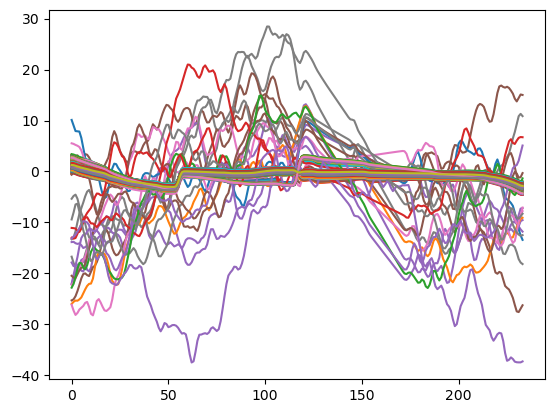

In [89]:
phase2.shape[0]
for i in range(phase2.shape[0]):
    plt.plot(range(234),phase2[i])

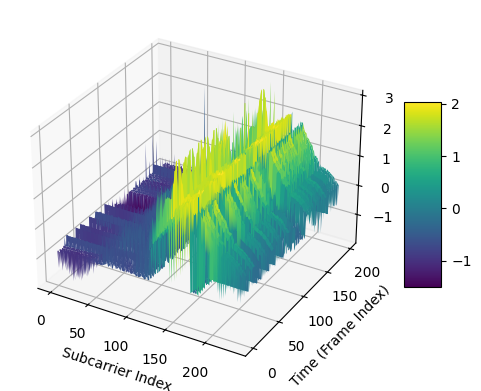

In [110]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 假設 amp2_p shape = (num_frames, num_subcarriers)
num_frames, num_subcarriers = amp1_p.shape

# 建立網格座標
X = np.arange(num_subcarriers)               # Subcarrier Index
Y = np.arange(num_frames)                    # Time Index
X, Y = np.meshgrid(X, Y)                     # X.shape, Y.shape => (num_frames, num_subcarriers)

Z = amp1_p                                  # 與 X, Y 之 shape 相同即可，如 (num_frames, num_subcarriers)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 畫 3D surface
# alpha可調整透明度, cmap可換色盤, 如 'viridis', 'jet', 'plasma'自己挑 或趣網上查
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 若想用 wireframe，可改用:
# ax.plot_wireframe(X, Y, Z, color='blue')

ax.set_xlabel('Subcarrier Index')
ax.set_ylabel('Time (Frame Index)')
ax.set_zlabel('Amplitude')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()



In [111]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp1.values, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp1.values, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp1.values, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: [ 90.71027744  93.86863546  84.8221799   83.81601719  92.68640417
  83.82605345  87.04250749  92.21285979  86.81330616  84.26691526
  82.85647798  92.20924506  75.70343533  79.78087764  74.13153218
  69.47245821  96.07228151  56.42402631  92.08039088  86.4840935
  48.30182682  52.6747937   70.51591838  55.42140111  51.44044386
  49.3472846   49.80830088  51.44196673  55.23877881  49.49771597
  48.86701437  50.7882948   51.7069344   56.00206031  64.3242602
  64.58634117  74.74981351  82.11089367  93.06721925  96.86412668
  95.20636985 100.83107955 102.9925489  104.40319949 107.20765445
 113.22841027 121.60024349 125.64167185 135.65109602 130.24905492
 133.01643675 148.01532136 166.97220912 163.51056713 163.20132629
 179.08065036 177.28190251 170.17832238 190.68672824 204.36566846
 218.27164812 223.71146133 204.56479484 208.84709105 206.20119566
 217.88345851 207.12975634 197.47262178 190.71816457 186.96820498
 205.61846495 203.36464064 209.85486712 218.08044358 188.6174865

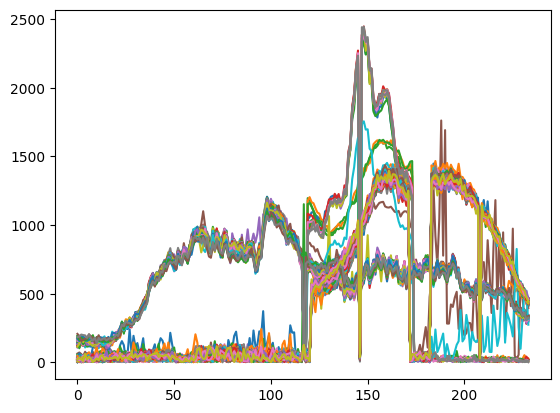

In [112]:
for i in range(amp2.shape[0]):
    plt.plot(range(234),amp2.iloc[i])
    

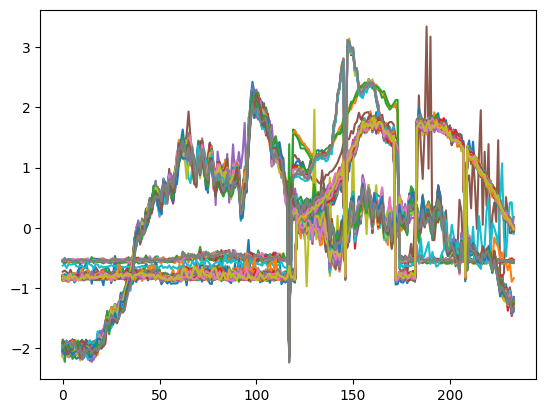

In [113]:
for i in range(amp2_p.shape[0]):
    plt.plot(range(234),amp2_p[i])

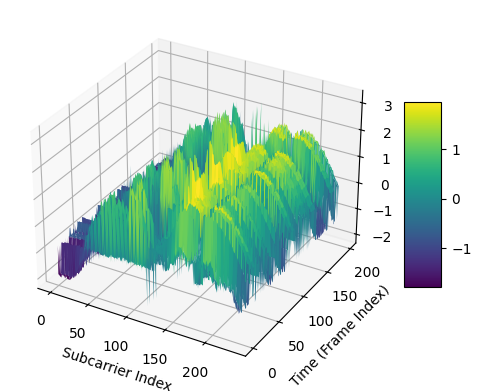

In [114]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 假設 amp2_p shape = (num_frames, num_subcarriers)
num_frames, num_subcarriers = amp2_p.shape

# 建立網格座標
X = np.arange(num_subcarriers)               # Subcarrier Index
Y = np.arange(num_frames)                    # Time Index
X, Y = np.meshgrid(X, Y)                     # X.shape, Y.shape => (num_frames, num_subcarriers)

Z = amp2_p                                   # 與 X, Y 之 shape 相同即可，如 (num_frames, num_subcarriers)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 畫 3D surface
# alpha可調整透明度, cmap可換色盤, 如 'viridis', 'jet', 'plasma'...
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 若想用 wireframe，可改用:
# ax.plot_wireframe(X, Y, Z, color='blue')

ax.set_xlabel('Subcarrier Index')
ax.set_ylabel('Time (Frame Index)')
ax.set_zlabel('Amplitude')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [115]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp1_p, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp1_p, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp1_p, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: [0.27233969 0.279026   0.24371851 0.24963294 0.28126986 0.26463649
 0.24811255 0.28953237 0.30585201 0.30220648 0.3252479  0.33684343
 0.3371944  0.34931021 0.37439884 0.38260279 0.4209978  0.39862681
 0.45736709 0.468834   0.44117663 0.43363396 0.47037055 0.39937692
 0.43544716 0.3889433  0.41751521 0.39834656 0.41996071 0.39357552
 0.38092286 0.38371254 0.38504643 0.37151195 0.34372982 0.33811913
 0.30569812 0.26700078 0.23284505 0.21969573 0.22876871 0.20290869
 0.20248693 0.17914887 0.16351778 0.144032   0.10259377 0.08152994
 0.07924988 0.07354099 0.07756617 0.10674173 0.14256015 0.13168804
 0.1298485  0.18071319 0.17347888 0.14956134 0.22051515 0.2729914
 0.32721489 0.34554227 0.31026124 0.32112503 0.30868534 0.34078128
 0.31366401 0.27964088 0.25799021 0.24085008 0.31076163 0.2883611
 0.32992328 0.35214046 0.2488613  0.26168304 0.35028146 0.35622052
 0.36309691 0.24741772 0.39296147 0.37664521 0.27436569 0.27404642
 0.31338716 0.29389395 0.247781   0.24337392 0.236

C:\Users\keng-tse\AppData\Local\Temp\ipykernel_29680\418209202.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"SC{i}" for i in range(data.shape[1])])


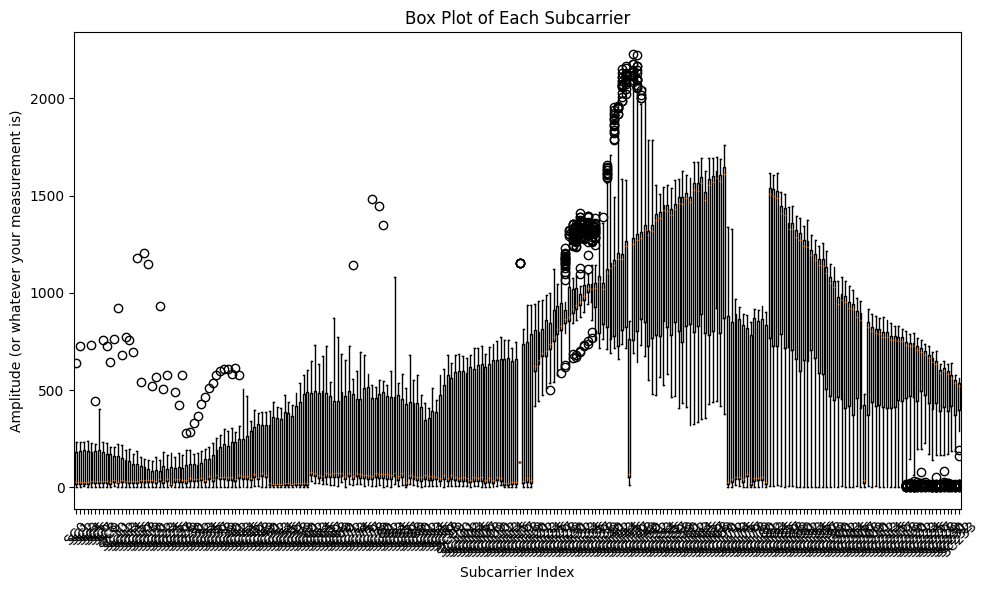

In [116]:
import matplotlib.pyplot as plt

# 假設 amp1.values.shape = (num_frames, num_subcarriers)
data = amp1.values  # 或 np.array(...)，形狀 (時間×子載波)

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=[f"SC{i}" for i in range(data.shape[1])])

plt.title("Box Plot of Each Subcarrier")
plt.xlabel("Subcarrier Index")
plt.ylabel("Amplitude (or whatever your measurement is)")
plt.xticks(rotation=45)  # 如果子載波多，可以稍微旋轉標籤避免重疊
plt.tight_layout()
plt.show()


C:\Users\keng-tse\AppData\Local\Temp\ipykernel_29680\2623628920.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f"SC{i}" for i in range(data.shape[1])])


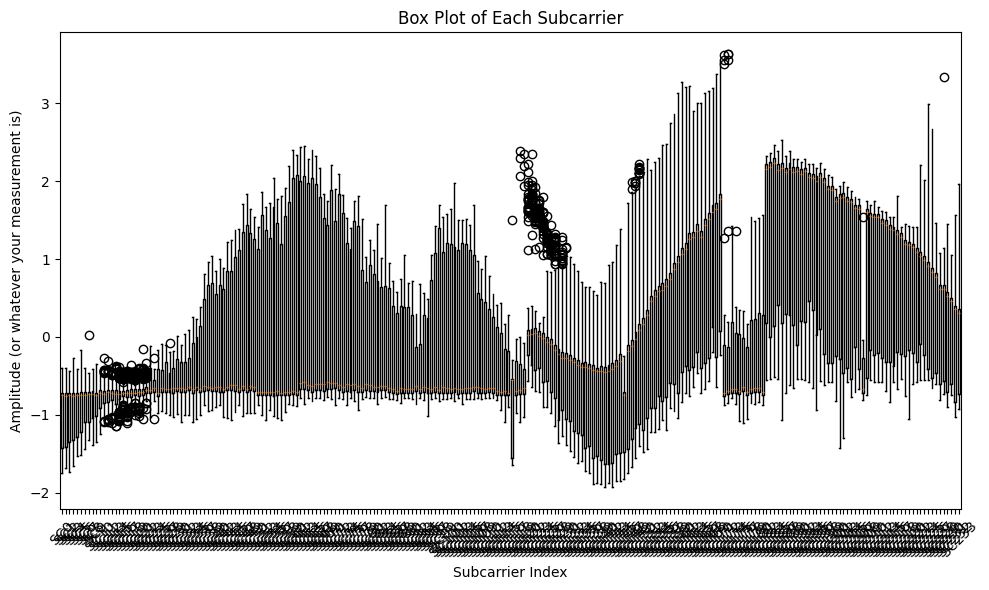

In [99]:
data = amp1_p
# 或 np.array(...)，形狀 (時間×子載波)

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=[f"SC{i}" for i in range(data.shape[1])])

plt.title("Box Plot of Each Subcarrier")
plt.xlabel("Subcarrier Index")
plt.ylabel("Amplitude (or whatever your measurement is)")
plt.xticks(rotation=45)  # 如果子載波多，可以稍微旋轉標籤避免重疊
plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (48,) and (234,)

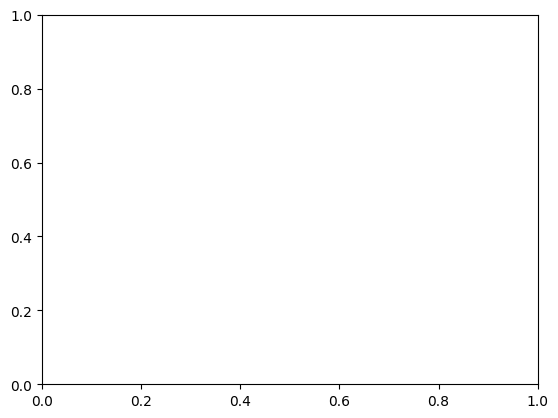

In [100]:
for i in range(amp2.shape[0]):
    plt.plot(range(48),amp2.iloc[i])

In [19]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp2.values, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp2.values, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp2.values, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")


各子載波統計量:
STD: [ 73.17151869  65.08702348  70.3107143   67.2243095   73.73709691
  68.11388947  63.16364024  50.01112221  54.15508215  65.46588404
  68.72884907  66.11917748  64.74862252  59.15553679  56.98058035
  50.19205263  49.76055063  54.37233035  81.33561401  77.0793605
 102.85106821  89.9263429   71.03814606  63.10866839  67.27916622
  65.86672064  86.71954027  98.0654002   72.37322716  77.79013222
  52.20943991  52.4300853   52.30137246  62.89155559  64.25470261
  79.48681268  79.55023543  84.52541213  80.85028472  66.31187985
  63.80122448  72.90339155  82.3454806   90.86299847  81.83492269
  86.27630494  78.97701246  82.67348555]
VAR: [ 5354.07114773  4236.32062512  4943.59654585  4519.10778829
  5437.15946117  4639.5019383   3989.64544801  2501.11234506
  2932.7729223   4285.78197373  4723.65469427  4371.74563124
  4192.38411772  3499.37753323  3246.78653653  2519.24214771
  2476.11239851  2956.35030804  6615.4821062   5941.22781448
 10578.34223174  8086.74714809  5046.41819

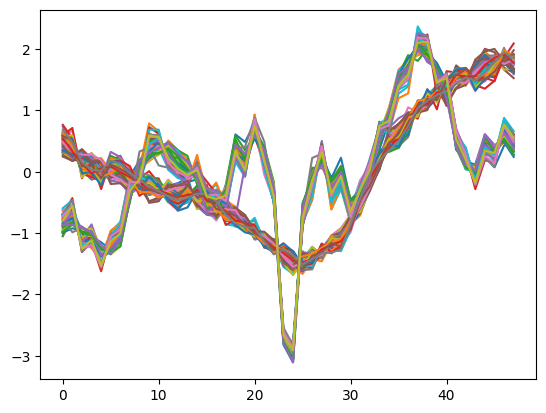

In [20]:
for i in range(amp2_p.shape[0]):
    plt.plot(range(48),amp2_p[i])

In [21]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp2_p, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp2_p, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp2_p, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: [0.67350441 0.54603434 0.6389569  0.58449601 0.69989651 0.62670772
 0.55358616 0.13999394 0.13045173 0.35248307 0.38767884 0.31850208
 0.30017027 0.19963481 0.2228001  0.11186048 0.12470339 0.15504358
 0.55784758 0.50441133 0.8429267  0.67163274 0.44250314 0.67309823
 0.74432799 0.39619256 0.63256383 0.79318857 0.45163649 0.5314757
 0.14016843 0.13416465 0.12775291 0.24842273 0.21679442 0.45874527
 0.43646474 0.53975963 0.45456187 0.1630953  0.11807509 0.50791392
 0.68891408 0.80470594 0.65120239 0.72750408 0.6087158  0.67402177]
VAR: [0.45360819 0.2981535  0.40826593 0.34163559 0.48985512 0.39276257
 0.30645764 0.0195983  0.01701765 0.12424431 0.15029488 0.10144358
 0.09010219 0.03985406 0.04963989 0.01251277 0.01555094 0.02403851
 0.31119392 0.25443079 0.71052542 0.45109054 0.19580903 0.45306123
 0.55402415 0.15696854 0.400137   0.6291481  0.20397552 0.28246642
 0.01964719 0.01800015 0.01632081 0.06171385 0.04699982 0.21044722
 0.19050147 0.29134046 0.2066265  0.0266000

In [22]:
data3 = pd.read_excel(r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\0212_time_ob\csv\reference_point3_1.xlsx")

In [23]:
amp3 = data3.iloc[:,:48]
amp3_p = denoise.preprocess_csi_for_fingerprint2(np.array(amp3))

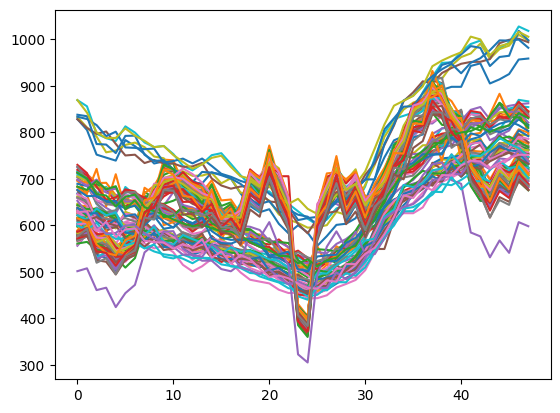

In [38]:
for i in range(amp3.shape[0]):
    if (amp3_p[i,:] < 4).all():
        plt.plot(np.arange(48),amp3.iloc[i,:])

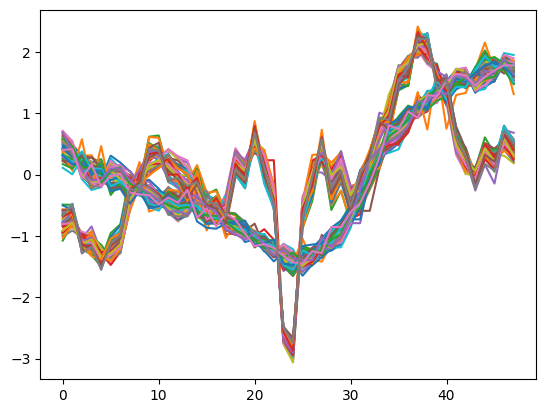

In [37]:
for i in range(amp3_p.shape[0]):
    if (amp3_p[i,:] < 4).all():
        plt.plot(np.arange(48),amp3_p[i,:])

In [39]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp3, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp3, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp3, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: 589.712642     74.120644
597.850316     64.780268
588.695167     69.552907
585.000000     64.177475
568.738956     72.970884
550.272660     69.308098
563.937053     62.859684
635.824661     47.532853
696.347614     48.084242
693.952448     61.367693
711.180708     63.813408
720.117352     58.812359
706.917958     58.084321
689.280785     52.820794
662.487736     54.017416
612.474489     46.991528
617.408293     46.821355
634.137209     47.220527
712.851317     74.118736
689.383783     70.391367
720.923019     98.495684
701.410721     83.549979
646.062690     66.666408
406.773893     63.317995
373.546517    750.033955
607.363153     62.632168
657.012176     82.756015
678.451914     96.926570
642.299774     69.183462
669.932832     74.306139
615.293426     47.428457
634.193977     49.953092
655.116783     52.549939
712.166413     60.144884
762.502459     57.741418
824.878779     74.332643
836.495666     73.882735
860.751416     81.968397
854.523259     77.738190
830.918167 

In [40]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp3_p, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp3_p, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp3_p, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: [0.63620904 0.51756412 0.63174195 0.56534968 0.68448064 0.60934268
 0.5272109  0.15246197 0.11567175 0.32796411 0.37224475 0.30702401
 0.29966894 0.22006811 0.22174778 0.13790678 0.13154412 0.16000149
 0.52460434 0.482417   0.80595319 0.63576082 0.44412334 0.6462061
 1.1355562  0.41454051 0.63413629 0.791098   0.46672874 0.53324753
 0.16921644 0.17528754 0.16129435 0.25490938 0.23162983 0.47188063
 0.45466977 0.54580044 0.47867845 0.20501901 0.19288563 0.52764337
 0.68527155 0.78852461 0.67705999 0.74357785 0.6246285  0.66412397]
VAR: [0.40476195 0.26787262 0.39909789 0.31962026 0.46851375 0.3712985
 0.27795134 0.02324465 0.01337995 0.10756046 0.13856615 0.09426374
 0.08980147 0.04842997 0.04917208 0.01901828 0.01730385 0.02560048
 0.27520971 0.23272616 0.64956055 0.40419182 0.19724554 0.41758232
 1.28948789 0.17184383 0.40212883 0.62583605 0.21783571 0.28435293
 0.0286342  0.03072572 0.02601587 0.06497879 0.05365238 0.22267133
 0.2067246  0.29789812 0.22913306 0.0420328 

In [41]:
data4 = pd.read_excel(r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone\0212_time_ob\csv\reference_point4_1.xlsx")
amp4 = data4.iloc[:,:48]
amp4_p = denoise.preprocess_csi_for_fingerprint2(np.array(amp4))

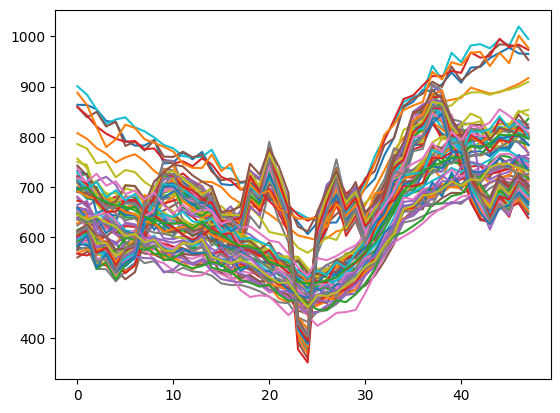

In [42]:
for i in range(amp4.shape[0]):
    plt.plot(np.arange(48),amp4.iloc[i,:])

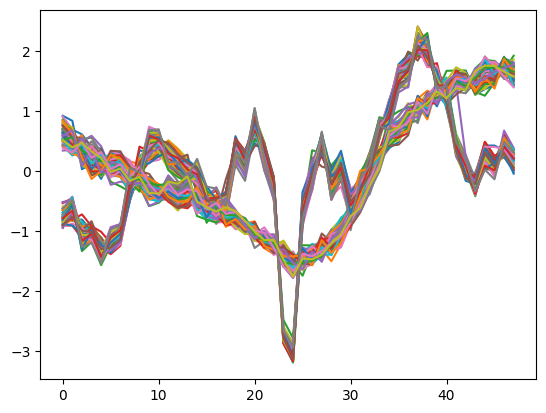

In [43]:
for i in range(amp4_p.shape[0]):
    plt.plot(np.arange(48),amp4_p[i,:])

In [321]:
# 逐个子载波计算统计量
subcarrier_std = np.std(amp4, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp4, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp4, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: 718.891508     74.607725
705.034751     65.770984
682.806708     72.547498
648.277718     65.275360
664.754090     74.203025
668.401077     68.047044
660.131048     63.052387
640.272598     48.093604
638.774608     50.592201
625.411864     62.471420
620.519943     65.653179
605.990924     57.952743
602.000831     56.633449
601.040764     51.241444
611.624068     55.356194
581.288225     44.743216
590.793534     46.935635
558.108412     46.095103
573.600907     75.247078
560.746823     71.184361
568.000880    100.640017
539.573906     84.809426
528.802421     67.090715
525.290396     62.753844
510.381230     68.818010
515.617106     62.385554
510.955967     81.099585
533.973782     97.732440
528.910200     66.872139
545.550181     72.573738
582.115109     46.136765
606.003300     48.905265
660.364293     50.253466
668.146690     57.232710
694.504140     55.740497
701.088439     70.435715
710.886770     69.200400
757.491914     78.880708
747.602167     72.141385
774.344239 

In [323]:
data_pi2 = df = pd.read_excel(r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone_pi2\P1P2\csv\reference_point_1_pi2.xlsx")

In [325]:
amp_pi2 = data_pi2.iloc[:,:48]
amp_pi2_p = denoise.preprocess_csi_for_fingerprint2(np.array(amp_pi2))

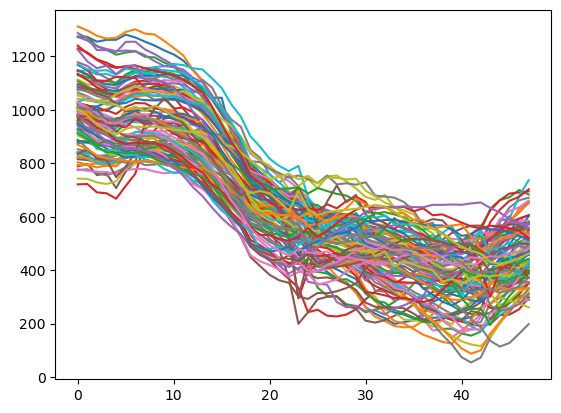

In [327]:
for i in range(amp_pi2.shape[0]):
    plt.plot(np.arange(48),amp_pi2.iloc[i,:])

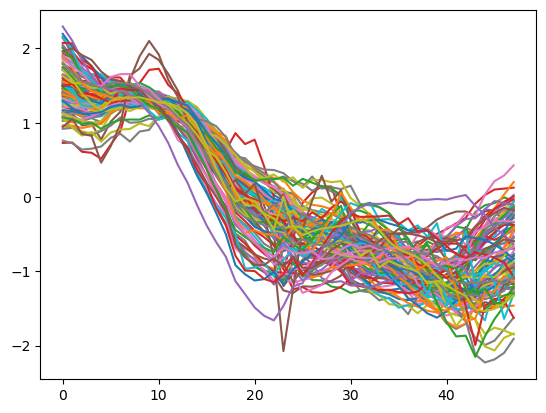

In [329]:
for i in range(amp_pi2_p.shape[0]):
    plt.plot(np.arange(48),amp_pi2_p[i,:])

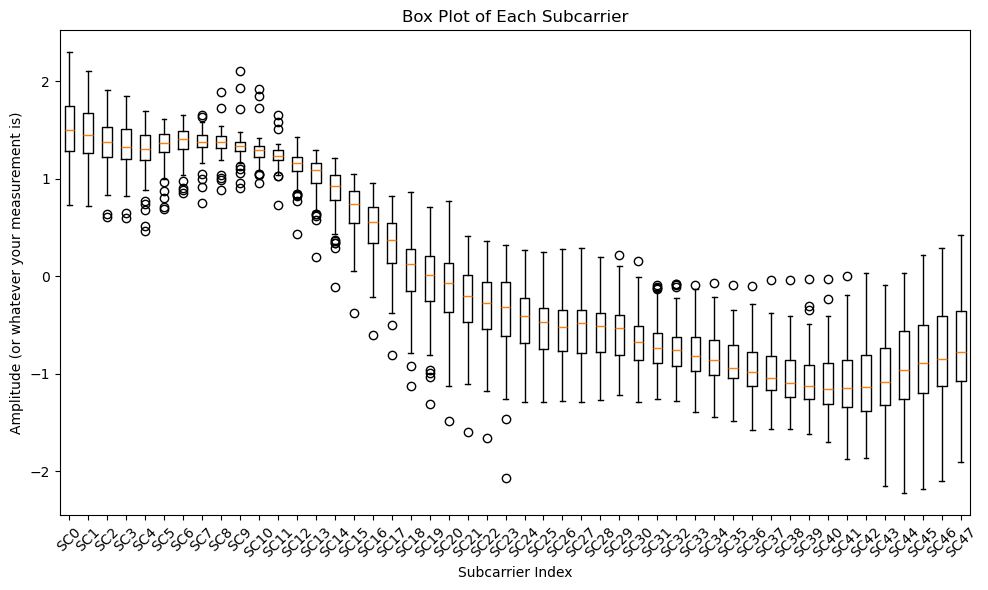

In [349]:

# 或 np.array(...)，形狀 (時間×子載波)

plt.figure(figsize=(10, 6))
plt.boxplot(amp_pi2_p, labels=[f"SC{i}" for i in range(data.shape[1])])

plt.title("Box Plot of Each Subcarrier")
plt.xlabel("Subcarrier Index")
plt.ylabel("Amplitude (or whatever your measurement is)")
plt.xticks(rotation=45)  # 如果子載波多，可以稍微旋轉標籤避免重疊
plt.tight_layout()
plt.show()

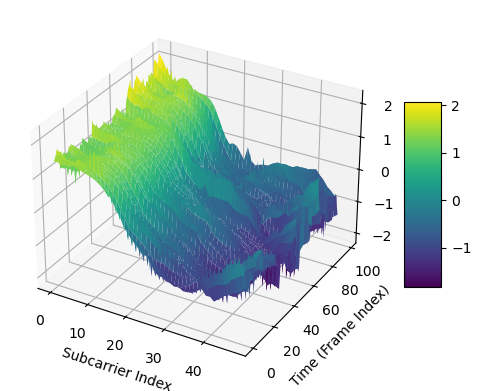

In [343]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 假設 amp2_p shape = (num_frames, num_subcarriers)
num_frames, num_subcarriers = amp_pi2_p.shape

# 建立網格座標
X = np.arange(num_subcarriers)               # Subcarrier Index
Y = np.arange(num_frames)                    # Time Index
X, Y = np.meshgrid(X, Y)                     # X.shape, Y.shape => (num_frames, num_subcarriers)

Z = amp_pi2_p                                  # 與 X, Y 之 shape 相同即可，如 (num_frames, num_subcarriers)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 畫 3D surface
# alpha可調整透明度, cmap可換色盤, 如 'viridis', 'jet', 'plasma'...
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 若想用 wireframe，可改用:
# ax.plot_wireframe(X, Y, Z, color='blue')

ax.set_xlabel('Subcarrier Index')
ax.set_ylabel('Time (Frame Index)')
ax.set_zlabel('Amplitude')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

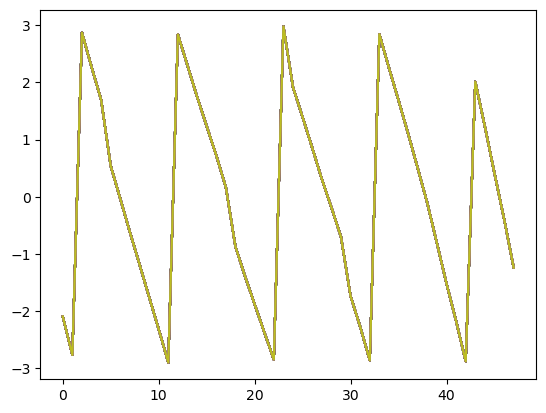

In [233]:
for i in range(amp_pi2.shape[0]):
    plt.plot(np.arange(48),data_pi2.iloc[80,48:-2])

In [235]:
subcarrier_std = np.std(amp_pi2_p, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp_pi2_p, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp_pi2_p, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: [0.34467987 0.30437278 0.27247149 0.24616529 0.23495473 0.18196935
 0.15308641 0.1314176  0.12579655 0.14023296 0.12991048 0.11995847
 0.14928909 0.1837141  0.22968703 0.2624605  0.29777647 0.32610715
 0.38145301 0.40098846 0.41045147 0.40354732 0.40580859 0.42971715
 0.35124037 0.3245085  0.31989339 0.31555706 0.29815297 0.30135945
 0.28310313 0.2702546  0.28742591 0.27963307 0.27312121 0.26596233
 0.26520856 0.27343599 0.29281442 0.30923178 0.32861137 0.36069513
 0.39830815 0.43266607 0.46822221 0.48007598 0.48229378 0.47962571]
VAR: [0.11880422 0.09264279 0.07424071 0.06059735 0.05520373 0.03311285
 0.02343545 0.01727059 0.01582477 0.01966528 0.01687673 0.01439003
 0.02228723 0.03375087 0.05275613 0.06888551 0.08867083 0.10634587
 0.1455064  0.16079174 0.16847041 0.16285044 0.16468062 0.18465683
 0.12336979 0.10530576 0.10233178 0.09957626 0.08889519 0.09081752
 0.08014738 0.07303755 0.08261366 0.07819466 0.0745952  0.07073596
 0.07033558 0.07476724 0.08574028 0.095624

In [189]:
data_pi1 = df = pd.read_excel(r"C:\Users\keng-tse\Desktop\csi_tool\csi_dataset\localization_phone_pi2\P1P2\csv\reference_point_1_pi1.xlsx")

In [191]:
amp_pi1 = data_pi1.iloc[:,:48]
amp_pi1_p = denoise.preprocess_csi_for_fingerprint2(np.array(amp_pi1))

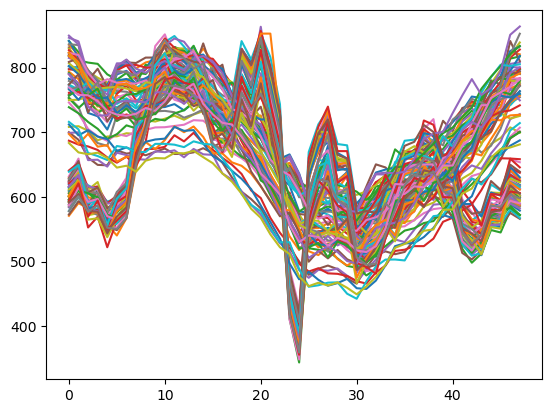

In [193]:
for i in range(amp_pi2.shape[0]):
    plt.plot(np.arange(48),amp_pi1.iloc[i,:])

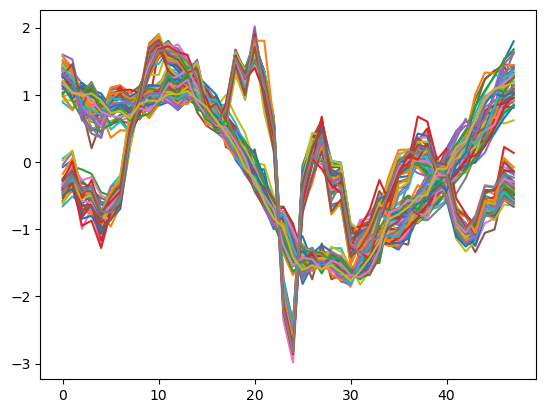

In [195]:
for i in range(amp_pi1_p.shape[0]):
    plt.plot(np.arange(48),amp_pi1_p[i,:])

In [239]:
subcarrier_std = np.std(amp_pi1_p, axis=0)  # 每个子载波的标准差
subcarrier_var = np.var(amp_pi1_p, axis=0)  # 每个子载波的方差
subcarrier_mean = np.mean(amp_pi1_p, axis=0)  # 每个子载波的均值
subcarrier_cv = subcarrier_std / subcarrier_mean  # 每个子载波的变异系数
print("各子載波統計量:")
print(f"STD: {subcarrier_std}")
print(f"VAR: {subcarrier_var}")
print(f"Mean: {subcarrier_mean}")
print(f"CV: {subcarrier_cv}")

print(f"STD mean: {np.mean(subcarrier_std)}")
print(f"VAR mean: {np.mean(subcarrier_var)}")
print(f"Mean mean: {np.mean(subcarrier_mean)}")
print(f"CV mean: {np.mean(subcarrier_cv)}")

各子載波統計量:
STD: [0.83597491 0.69085234 0.73668174 0.67214012 0.77648745 0.75719412
 0.69340246 0.22545582 0.10788387 0.28525013 0.34660685 0.26898127
 0.26953418 0.17893822 0.1933191  0.14126034 0.13035765 0.15994041
 0.62048509 0.58139308 0.94487917 0.82065341 0.62018017 0.54065897
 0.69018483 0.5675852  0.79933123 0.91575013 0.60088078 0.66841253
 0.28266763 0.23927825 0.2235742  0.29004671 0.27846823 0.44852091
 0.41038628 0.42925997 0.36284629 0.16748996 0.19279874 0.49048974
 0.65363716 0.72332525 0.6532988  0.74921315 0.71312314 0.80365628]
VAR: [0.69885405 0.47727695 0.54269999 0.45177235 0.60293276 0.57334294
 0.48080697 0.05083032 0.01163893 0.08136764 0.12013631 0.07235092
 0.07264868 0.03201889 0.03737227 0.01995448 0.01699312 0.02558094
 0.38500174 0.33801791 0.89279664 0.67347202 0.38462344 0.29231212
 0.4763551  0.32215296 0.63893041 0.83859831 0.36105771 0.44677531
 0.07990099 0.05725408 0.04998542 0.08412709 0.07754456 0.20117101
 0.1684169  0.18426412 0.13165743 0.028052